In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization, 
    Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2

In [ ]:
# Constants
FEATURE_X_SIZE = 128
FEATURE_Y_SIZE = 130
SAMPLE_RATE = 22050
AUDIO_DURATION = 3.0
N_CLASSES = 10

def normalize_audio(audio, target_dB=-15):
    """Normalize audio with peak normalization and target dB."""
    audio = librosa.util.normalize(audio)
    return audio * (10 ** (target_dB / 20))

In [7]:
def augment_audio(y, sr):
    """Apply random augmentations to audio."""
    # Random time stretch
    if np.random.random() > 0.5:
        stretch_factor = np.random.uniform(0.9, 1.1)
        y = librosa.effects.time_stretch(y, rate=stretch_factor)
    
    # Random pitch shift
    if np.random.random() > 0.5:
        n_steps = np.random.randint(-2, 3)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    
    # Random noise addition
    if np.random.random() > 0.5:
        noise_factor = np.random.uniform(0.001, 0.005)
        noise = np.random.normal(0, noise_factor, len(y))
        y = y + noise
    
    return y

def preprocess_audio_to_mel(filepath, augment=False):
    """Enhanced audio preprocessing with optional augmentation."""
    y, sr = librosa.load(filepath, sr=SAMPLE_RATE, duration=AUDIO_DURATION)
    
    if augment:
        y = augment_audio(y, sr)
    
    y = normalize_audio(y)
    
    # Calculate mel spectrogram with improved parameters
    mel_spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sr,
        n_mels=FEATURE_X_SIZE,
        fmax=sr/2,
        hop_length=512,
        n_fft=2048
    )
    
    # Convert to log scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalize the spectrogram
    mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / mel_spec_db.std()
    
    # Ensure consistent size
    if mel_spec_db.shape[1] > FEATURE_Y_SIZE:
        mel_spec_db = mel_spec_db[:, :FEATURE_Y_SIZE]
    elif mel_spec_db.shape[1] < FEATURE_Y_SIZE:
        pad_width = FEATURE_Y_SIZE - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), 'constant')
    
    return mel_spec_db

def load_data(data_path, is_train=True):
    """Load and preprocess audio data with augmentation for training."""
    labels = sorted(os.listdir(data_path))
    data_matrix, data_labels = [], []
    
    for label in labels:
        label_path = os.path.join(data_path, label)
        if os.path.isdir(label_path):
            files = [f for f in os.listdir(label_path) if f.endswith('.wav')]
            for file in files:
                filepath = os.path.join(label_path, file)
                
                # Original sample
                mel_spec = preprocess_audio_to_mel(filepath, augment=False)
                data_matrix.append(mel_spec)
                data_labels.append(label)
                
                # Augmented samples for training
                if is_train:
                    for _ in range(2):  # Create 2 augmented versions
                        mel_spec_aug = preprocess_audio_to_mel(filepath, augment=True)
                        data_matrix.append(mel_spec_aug)
                        data_labels.append(label)

    data_matrix = np.array(data_matrix)
    data_matrix = data_matrix[..., np.newaxis]
    
    label_encoder = LabelEncoder()
    data_labels = label_encoder.fit_transform(data_labels)
    data_labels = to_categorical(data_labels, num_classes=len(labels))
    
    return data_matrix, data_labels, label_encoder


In [8]:
def create_improved_model(input_shape, num_classes):
    """Create an improved CNN model with residual connections."""
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # First block
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Second block
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Third block
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Fourth block
        Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        
        # Output layer
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

In [ ]:
TRAIN_PATH='./data/train'
# Load and prepare data
X_train, y_train, label_encoder = load_data(TRAIN_PATH)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and compile model
input_shape = (FEATURE_X_SIZE, FEATURE_Y_SIZE, 1)
model = create_improved_model(input_shape, N_CLASSES)

In [17]:
# Use a custom learning rate schedule
initial_learning_rate = 1e-3
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train with improved parameters
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save("final_model.keras")

Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.2096 - loss: 7.8077
Epoch 1: val_accuracy improved from -inf to 0.32106, saving model to best_model.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 404s 897ms/step - accuracy: 0.2097 - loss: 7.8040 - val_accuracy: 0.3211 - val_loss: 3.8729 - learning_rate: 0.0010
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.3794 - loss: 3.3576
Epoch 2: val_accuracy improved from 0.32106 to 0.39387, saving model to best_model.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 392s 881ms/step - accuracy: 0.3795 - loss: 3.3567 - val_accuracy: 0.3939 - val_loss: 2.5006 - learning_rate: 0.0010
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.4696 - loss: 2.2336
Epoch 3: val_accuracy did not improve from 0.39387
445/445 ━━━━━━━━━━━━━━━━━━━━ 392s 882ms/step - accuracy: 0.4697 - loss: 2.2333 - val_accuracy: 0.3455 - val_loss: 2.3896 - learning_rate: 0.0010
Epoch 4/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5169 - 

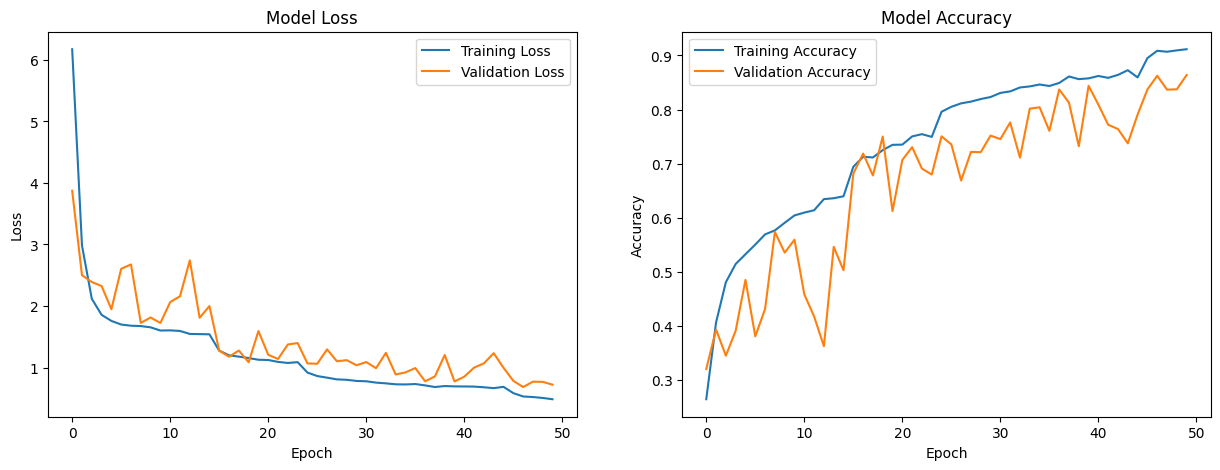

In [18]:
# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


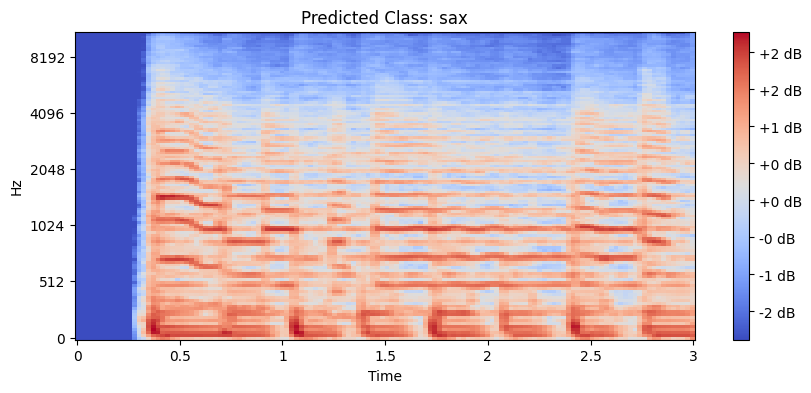

Predicted Label: sax


In [21]:
# Function to predict and display spectrogram
def predict_audio_class(filepath, model, label_encoder):
    """Predict the class of an audio file and display Mel spectrogram."""
    mel_spec = preprocess_audio_to_mel(filepath)
    mel_spec = mel_spec[np.newaxis, ..., np.newaxis]  # Reshape for prediction
    prediction = model.predict(mel_spec)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    
    # Display Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec[0, :, :, 0], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Predicted Class: {predicted_label}')
    plt.show()
    
    return predicted_label

# Test prediction on an example audio file
example_file = os.path.join('./data/test', 'audio', '(02) dont kill the whale-1.wav')  
predicted_label = predict_audio_class(example_file, model, label_encoder)
print(f'Predicted Label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


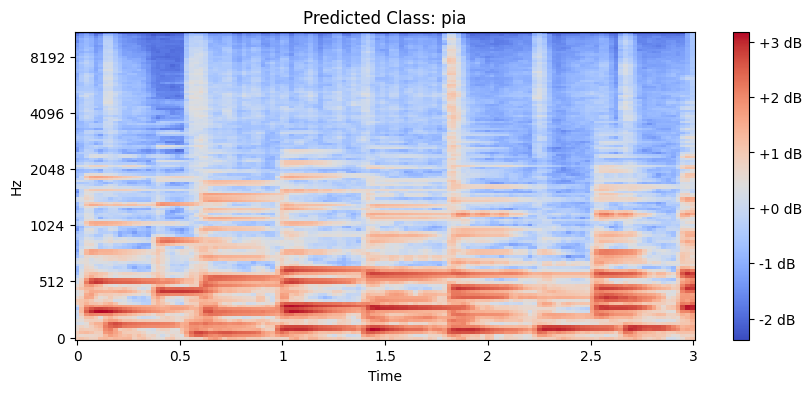

Predicted Label: pia


In [22]:
# Test prediction on an example audio file
example_file = os.path.join('./data', 'test/audio','01. It Don\'t Mean a Thing (If It Ain\'t Got That Swing)-3.wav')  
predicted_label = predict_audio_class(example_file, model, label_encoder)
print(f'Predicted Label: {predicted_label}')

In [23]:

TEST_DIR = './data/test'  # Directory containing 'audio' and 'annotations' subdirectories
MODEL_PATH = './final_model.keras'  # Path to your saved model
OUTPUT_DIR = './test_results'  # Directory to save results

In [29]:
def evaluate_test_set(test_dir, model, label_encoder):
    """
    Evaluate entire test set and generate comprehensive results.
    Modified to handle multiple true labels per file and missing classes.
    """
    test_files = load_test_data(test_dir)
    results = []
    true_labels_for_metrics = []
    predicted_labels = []
    skipped_files = []
    
    # Keep track of encountered labels
    encountered_labels = set()
    
    for audio_path, true_labels in test_files:
        try:
            result = test_single_file(audio_path, model, label_encoder)
            if result:
                # Check if any of the true labels are in our known classes
                valid_labels = [label for label in true_labels if label in label_encoder.classes_]
                
                if valid_labels:
                    result['true_labels'] = true_labels
                    result['matched_label'] = None
                    
                    # Check if prediction matches any of the valid labels
                    if result['predicted_label'] in valid_labels:
                        result['matched_label'] = result['predicted_label']
                    
                    results.append(result)
                    # For metrics, use the first valid label if prediction doesn't match any
                    true_label = valid_labels[0]
                    true_labels_for_metrics.append(true_label)
                    predicted_labels.append(result['predicted_label'])
                    
                    # Update encountered labels
                    encountered_labels.update(valid_labels)
                    encountered_labels.add(result['predicted_label'])
                else:
                    skipped_files.append({
                        'filename': os.path.basename(audio_path),
                        'true_labels': true_labels,
                        'reason': 'No valid labels'
                    })
        except Exception as e:
            skipped_files.append({
                'filename': os.path.basename(audio_path),
                'true_labels': true_labels,
                'reason': str(e)
            })
    
    # Calculate metrics only if we have valid results
    if results:
        # Get list of labels that actually appear in the data
        active_labels = sorted(list(encountered_labels))
        
        # Calculate classification report with zero_division=0 to handle missing classes
        class_report = classification_report(
            true_labels_for_metrics, 
            predicted_labels, 
            labels=active_labels,  # Only use labels that appear in the data
            zero_division=0,  # Handle missing classes gracefully
            output_dict=True
        )
        
        # Calculate confusion matrix only for active labels
        conf_matrix = confusion_matrix(
            true_labels_for_metrics, 
            predicted_labels,
            labels=active_labels
        )
        
        total_files = len(results)
        correct_predictions = sum(1 for r in results if r['matched_label'] is not None)
        accuracy = correct_predictions / total_files if total_files > 0 else 0
        avg_confidence = sum(r['confidence'] for r in results) / total_files if total_files > 0 else 0
        
        # Add additional metrics about class distribution
        class_distribution = {
            'true_label_distribution': {label: true_labels_for_metrics.count(label) 
                                      for label in active_labels},
            'predicted_label_distribution': {label: predicted_labels.count(label) 
                                           for label in active_labels}
        }
        
        return {
            'individual_results': results,
            'skipped_files': skipped_files,
            'metrics': {
                'accuracy': accuracy,
                'average_confidence': avg_confidence,
                'total_processed': total_files,
                'total_skipped': len(skipped_files),
                'class_report': class_report,
                'multi_label_matches': correct_predictions,
                'class_distribution': class_distribution,
                'active_labels': active_labels,
                'unused_labels': [label for label in label_encoder.classes_ 
                                if label not in active_labels]
            },
            'confusion_matrix': conf_matrix,
            'label_names': active_labels  # Only use active labels for confusion matrix
        }
    else:
        return {
            'error': 'No valid results generated',
            'skipped_files': skipped_files
        }

def run_complete_evaluation(test_dir, model_path, label_encoder_path):
    """
    Run complete evaluation pipeline and save results.
    """
    try:
        # Load the model and label encoder
        print("Loading model...")
        model = tf.keras.models.load_model(model_path)
        
        print("Loading label encoder...")
        label_encoder = load_label_encoder(label_encoder_path)
        
        print("Running evaluation...")
        results = evaluate_test_set(test_dir, model, label_encoder)
        
        if 'error' not in results:
            # Create output directory
            output_dir = os.path.join(os.path.dirname(model_path), 'test_results')
            os.makedirs(output_dir, exist_ok=True)
            
            # Save results to CSV
            print("Saving results...")
            results_df = pd.DataFrame(results['individual_results'])
            results_df['true_labels'] = results_df['true_labels'].apply(lambda x: '|'.join(x))
            results_df.to_csv(os.path.join(output_dir, 'predictions.csv'), index=False)
            
            skipped_df = pd.DataFrame(results['skipped_files'])
            skipped_df['true_labels'] = skipped_df['true_labels'].apply(lambda x: '|'.join(x))
            skipped_df.to_csv(os.path.join(output_dir, 'skipped_files.csv'), index=False)
            
            # Save class distribution
            pd.DataFrame(results['metrics']['class_distribution']).to_csv(
                os.path.join(output_dir, 'class_distribution.csv')
            )
            
            # Save confusion matrix plot
            if len(results['individual_results']) > 0:
                plt.figure(figsize=(10, 8))
                sns.heatmap(
                    results['confusion_matrix'], 
                    annot=True, 
                    fmt='d', 
                    cmap='Blues',
                    xticklabels=results['label_names'],
                    yticklabels=results['label_names']
                )
                plt.title('Confusion Matrix')
                plt.ylabel('True Label')
                plt.xlabel('Predicted Label')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
                plt.close()
            
            # Print summary
            print("\nTest Results Summary:")
            print(f"Total Files Processed: {results['metrics']['total_processed']}")
            print(f"Files Skipped: {results['metrics']['total_skipped']}")
            print(f"Overall Accuracy: {results['metrics']['accuracy']:.2%}")
            print(f"Average Confidence: {results['metrics']['average_confidence']:.2%}")
            print(f"Multi-label Matches: {results['metrics']['multi_label_matches']}")
            print("\nLabel Usage:")
            print(f"Active Labels: {len(results['metrics']['active_labels'])}")
            print(f"Unused Labels: {len(results['metrics']['unused_labels'])}")
            
            if results['metrics']['unused_labels']:
                print("\nWarning: The following labels were not found in the test set:")
                print(', '.join(results['metrics']['unused_labels']))
            
        else:
            print("\nEvaluation Error:")
            print(results['error'])
            print(f"Total Files Skipped: {len(results['skipped_files'])}")
            
        return results
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")
        return {'error': str(e)}

In [30]:
# After training
save_label_encoder(label_encoder, 'label_encoder.json')
# Testing
results = run_complete_evaluation('./data/test', 'final_model.keras', 'label_encoder.json')

Loading model...
Loading label encoder...
Running evaluation...
Saving results...

Test Results Summary:
Total Files Processed: 747
Files Skipped: 60
Overall Accuracy: 64.26%
Average Confidence: 82.44%
Multi-label Matches: 480

Label Usage:
Active Labels: 10
Unused Labels: 0


Accuracy: 0.09
Predicted counts for each instrument:
pia                27
pia|sax            23
gac                12
gel|voi            11
gel|pia             9
pia|voi             9
gac|voi             9
cel|vio|voi         8
gel|org|sax         7
gel                 5
pia|tru             5
flu|gac             4
org                 3
org|pia|voi         3
gel|org             3
gac|vio             2
gel|tru             2
flu|pia             1
cla                 1
pia|sax|tru         1
sax|tru             1
gac|gel             1
gac|gel|sax|tru     1
flu|gel|pia         1
org|pia             1
Name: count, dtype: int64

The majority predicted instrument is 'pia' with 27 occurrences.


C:\Users\91936\AppData\Local\Temp\ipykernel_16356\1029284742.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_counts.index, y=predicted_counts.values, palette="viridis")


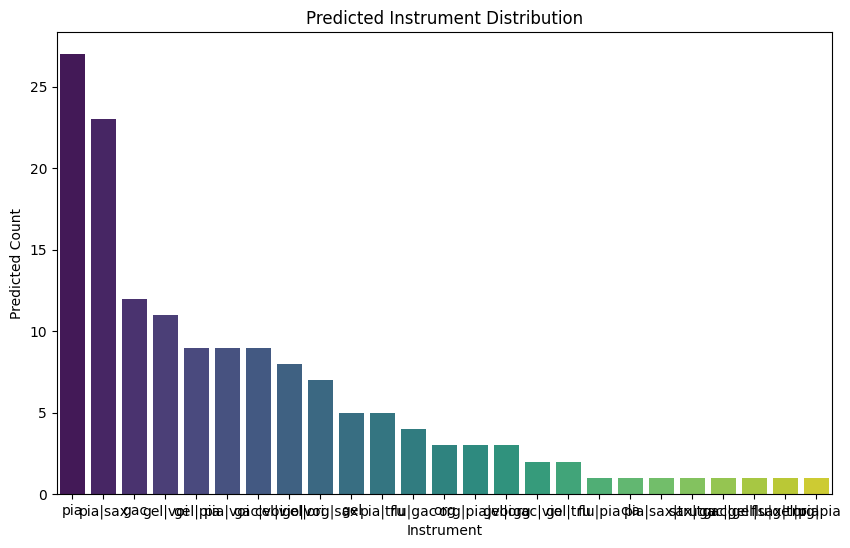

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import ast
data = pd.read_csv('./test_results/predictions.csv')
# Convert the 'probabilities' column from string representation to a list of floats
data['probabilities'] = data['probabilities'].apply(ast.literal_eval)

# Extract the maximum probability from each list in 'probabilities' as a feature
data['max_probability'] = data['probabilities'].apply(max)

# Select features and target variable
X = data[['confidence', 'max_probability']]  # Features: confidence and max_probability
y = data['true_labels']  # Target: true instrument labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Count the occurrences of each predicted label to determine the majority instrument
predicted_counts = pd.Series(y_pred).value_counts()
majority_instrument = predicted_counts.idxmax()
majority_count = predicted_counts.max()

print("Predicted counts for each instrument:")
print(predicted_counts)
print(f"\nThe majority predicted instrument is '{majority_instrument}' with {majority_count} occurrences.")

# Visualize the distribution of predictions
plt.figure(figsize=(10, 6))
sns.barplot(x=predicted_counts.index, y=predicted_counts.values, palette="viridis")
plt.xlabel("Instrument")
plt.ylabel("Predicted Count")
plt.title("Predicted Instrument Distribution")
plt.show()
